In [1]:
import pyqlab
from pyqlab.dataset import Dataset
from pyqlab.sigprocess import *
import scipy
from scipy.ndimage import gaussian_filter1d

In [2]:
import torch
import numpy as np

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
import plotly
import dash
from tqdm.auto import tqdm
import seaborn as sns
sns.set_theme()

In [4]:
rawdata_08_bias200mV=Dataset('/home/qqing/data/08_tunneling_bias_200mV.h5')

In [5]:
data=rawdata_08_bias200mV

bias_datalist=[]
bias_data=[]
current_datalist=[]
current_data=[]

dlist=data['/Tunneling bias '].dataset_list
for i, id in tqdm(enumerate(dlist), total=len(dlist), desc="Reading bias data   :"):
    bias_datalist.append(data.get_path(id))
    bias_data.append(data[id].data)
bias=np.concatenate(bias_data)

dlist=data['/Tunneling current '].dataset_list
for i, id in tqdm(enumerate(dlist), total=len(dlist), desc="Reading current data    :"):
    current_datalist.append(data.get_path(id))
    current_data.append(data[id].data)
current=np.concatenate(current_data)

conductance = (-current*1e9)/bias

Reading bias data   ::   0%|          | 0/21 [00:00<?, ?it/s]

Reading current data    ::   0%|          | 0/21 [00:00<?, ?it/s]

In [6]:
cut_off=1500.0 #Hz
fs = 50000.0 #Hz
gaussian_sigma=100

xscale_forward = lambda a: a*(1/fs)
xscale_inverse = lambda a: a*fs

conductance_smooth=lowpass_butterfly(conductance, cut_off, fs)
conductance_gaussianfiltered=gaussian_filter1d(conductance_smooth, gaussian_sigma)

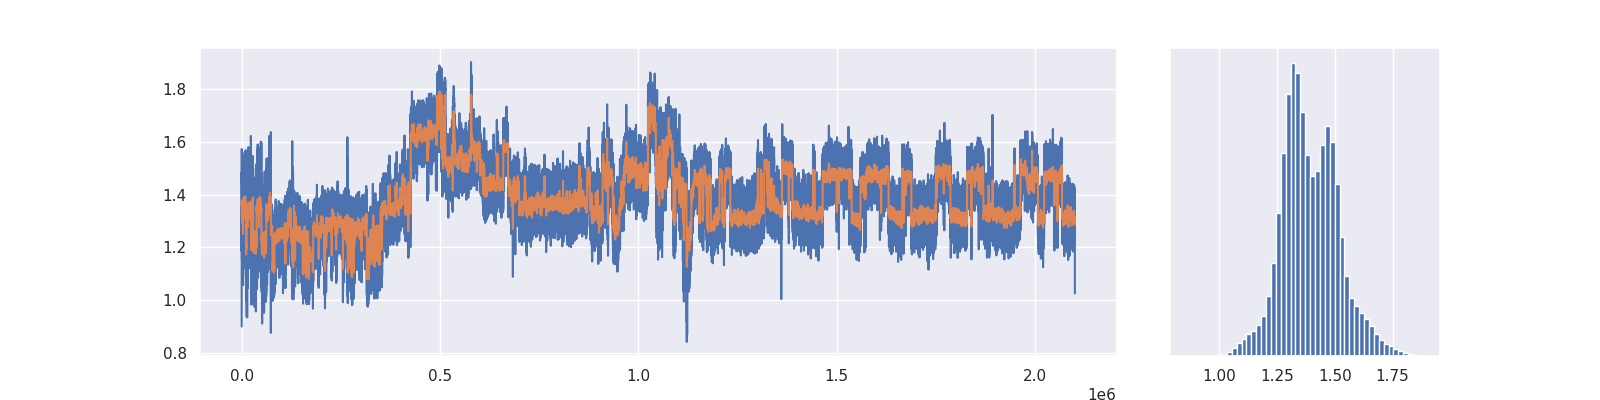

In [7]:

fig_cond=plt.figure()
fig_cond.set_figheight(4)
fig_cond.set_figwidth(16)

plt.subplot(1, 4, (1, 3))
plt.plot(conductance_smooth)
plt.plot(conductance_gaussianfiltered)
plt.xscale('function', functions=(xscale_forward, xscale_inverse))

plt.subplot(1, 4, 4)
plt.hist(conductance_smooth, bins=50)
fig_cond.axes[1].get_yaxis().set_visible(False)
plt.show()

In [8]:
plt.close(fig_cond)

In [9]:
step_vector=np.concatenate((np.ones(100, dtype=float), -1*np.ones(100, dtype=float)))

No such comm: 8367ee484e4b48f3b7bd372ec88a1be3
No such comm: 8367ee484e4b48f3b7bd372ec88a1be3


No such comm: b7ea24be9d2a4b5b993977281bc3b119
No such comm: b7ea24be9d2a4b5b993977281bc3b119


In [10]:
conv_cond = np.convolve(conductance_gaussianfiltered, step_vector)
delta_len=conv_cond.size-conductance_smooth.size

threshold=3
idx= np.abs(conv_cond)>threshold
t=np.arange(0, conv_cond.size)

t_sel=t[idx]
t_sel-=delta_len

conv_cond_sel=conductance_gaussianfiltered[t_sel]

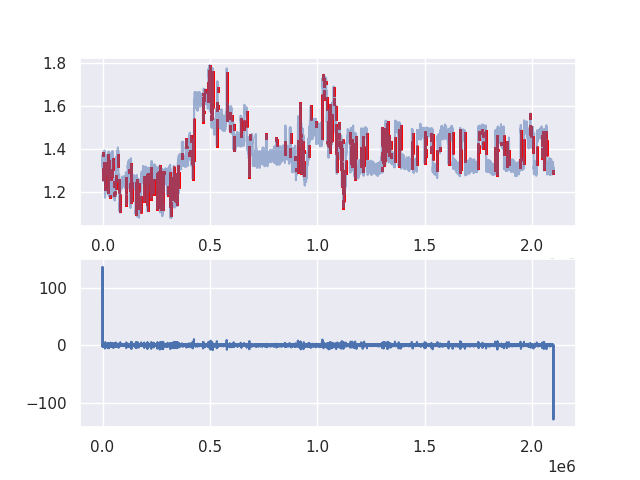

In [11]:
fig_convolve, ax=plt.subplots(2, 1)

ax[0].plot(conductance_gaussianfiltered, alpha=0.5)
ax[0].scatter(t_sel, conv_cond_sel, s=1, c='red')

ax[1].plot(t, conv_cond)

plt.show()

In [12]:
from AutoStepFinder.stepfindCore import *

In [48]:

dataX = conductance_gaussianfiltered
FitX = 0 * dataX
tresH=0.3
N_iter=10000

for ii in tqdm(range(0, 3, 1), desc="iterations with updated residue:"):
    # work remaining part of data:
    residuX = dataX - FitX
    newFitX, _, _, S_curve, best_shot = stepfindcore(
        residuX, 0, tresH, N_iter
    )
    FitX = st.AppendFitX(newFitX, FitX, dataX)
    # storage for plotting:
    if ii == 0:
        Fits = np.copy(FitX)
        S_curves = np.copy(S_curve)
        best_shots = [best_shot]
    elif best_shot > 0:
        Fits = np.vstack([Fits, FitX])
        S_curves = np.vstack([S_curves, S_curve])
        best_shots = np.hstack([best_shots, best_shot])


iterations with updated residue::   0%|          | 0/3 [00:00<?, ?it/s]

iterations for best fit::   0%|          | 0/10000 [00:00<?, ?it/s]

iterations for best fit::   0%|          | 0/10000 [00:00<?, ?it/s]

iterations for best fit::   0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
print(Fits.shape)
print(best_shots)
print(S_curves)

(2, 2100000)
[ 118 3473]
[[ 3.74930435e-01  8.15500459e-02  1.09775482e-01 ...  2.30017564e-04
   1.00798374e-04  0.00000000e+00]
 [ 1.58708315e-03  1.30985752e-02  6.56753372e-03 ...  6.56183674e-04
  -2.28682923e-04  0.00000000e+00]]


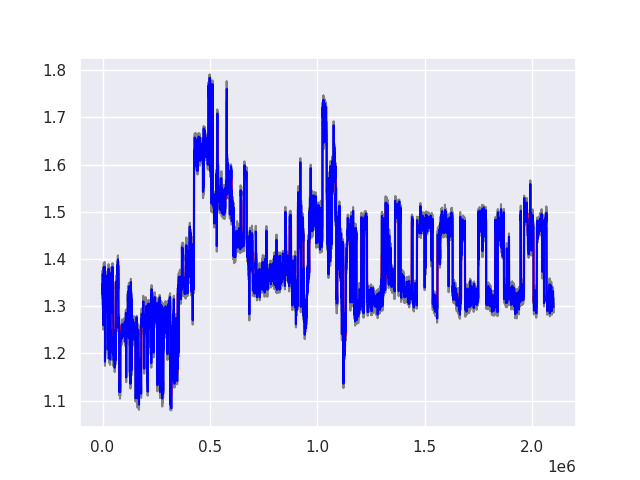

In [50]:
#if fig_fit:
#    plt.close(fig_fit)
fig_fit=plt.figure()
plt.plot(conductance_gaussianfiltered, c='gray')
plt.plot(Fits[0], c='red')
plt.plot(Fits[1], c='blue')
plt.show()

In [16]:
plt.close()

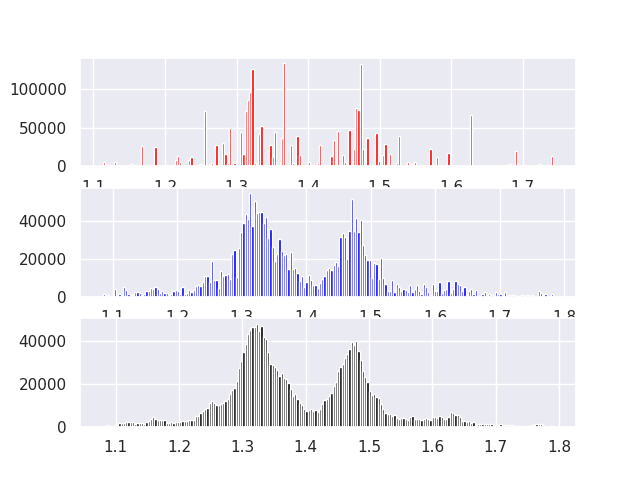

In [52]:
fig_fit_hist, ax=plt.subplots(3, 1)

ax[0].hist(Fits[0], bins=200, color='red')

ax[1].hist(Fits[1], bins=200, color='blue')

ax[2].hist(conductance_gaussianfiltered, bins=200, color='black')
plt.show()

In [ ]:
# model=fit_GMModel(Fits[1].reshape(-1, 1), max_components=8, max_iter=1000, verbose=10, method='gaussian')
# plot_GMModel(Fits[1].reshape(-1, 1), model["best_model"])

total # of components: 7


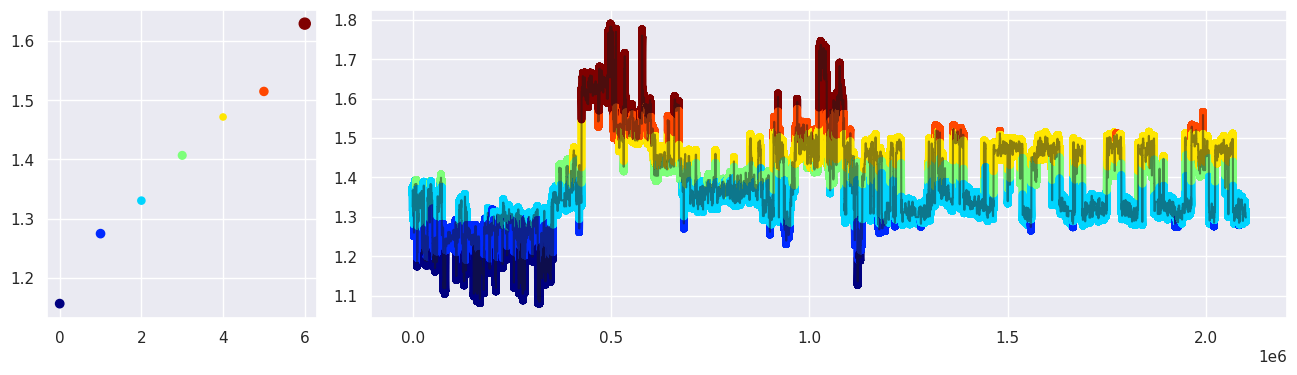

In [46]:
# labelled_data, model_param, colortable = label_data_with_model(Fits[1].reshape(-1, 1), conductance_gaussianfiltered.reshape(-1, 1), model["all_evaluated_models"][6], plot=True)

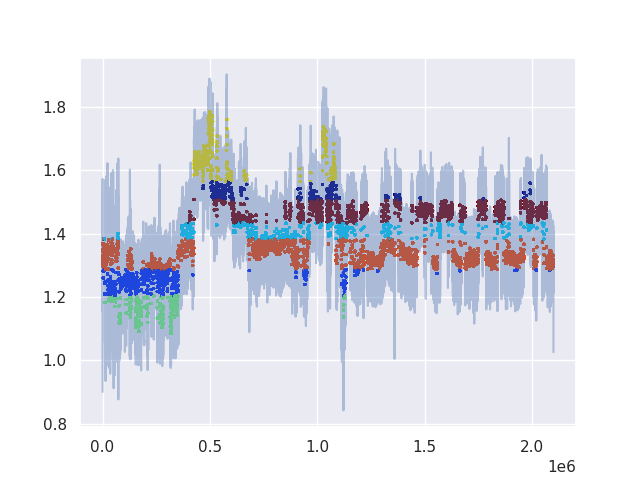

In [47]:
#plt.close(fig_label)
# colors=np.array([colortable[c][0:3] for c in labelled_data["data_label"]])
# fig_label=plt.figure()
# plt.plot(conductance_smooth, alpha=0.4)
# plt.scatter(np.arange(0, labelled_data["data_for_predict"].size), labelled_data["data_for_predict"], s=1, c=colors)
# plt.show()


In [62]:
dataX2 = conductance_gaussianfiltered
FitX2 = 0 * dataX2
tresH2=0.15
N_iter2=2500

for ii in tqdm(range(0, 3, 1), desc="iterations with updated residue:"):
    # work remaining part of data:
    residuX2 = dataX2 - FitX2
    newFitX2, _, _, S_curve2, best_shot2 = stepfindcore(
        residuX2, 0, tresH2, N_iter2
    )
    FitX2 = st.AppendFitX(newFitX2, FitX2, dataX2)
    # storage for plotting:
    if ii == 0:
        Fits2 = np.copy(FitX2)
        S_curves2 = np.copy(S_curve2)
        best_shots2 = [best_shot2]
    elif best_shot2 > 0:
        Fits2 = np.vstack([Fits2, FitX2])
        S_curves2 = np.vstack([S_curves2, S_curve2])
        best_shots2 = np.hstack([best_shots2, best_shot2])


iterations with updated residue::   0%|          | 0/3 [00:00<?, ?it/s]

iterations for best fit::   0%|          | 0/2500 [00:00<?, ?it/s]

iterations for best fit::   0%|          | 0/2500 [00:00<?, ?it/s]

iterations for best fit::   0%|          | 0/2500 [00:00<?, ?it/s]

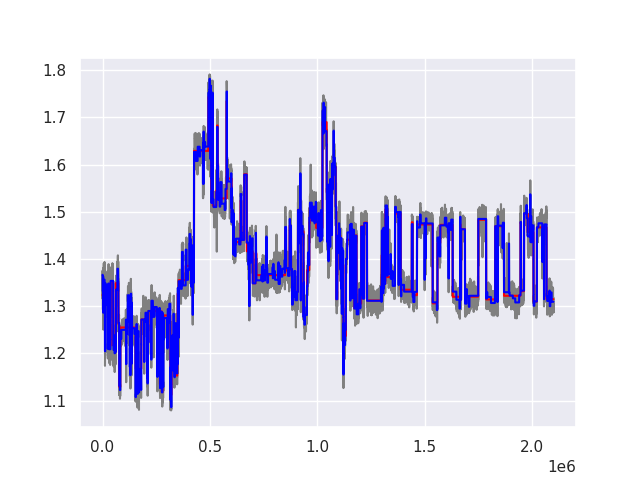

In [63]:
fig_fit=plt.figure()
plt.plot(conductance_gaussianfiltered, c='gray')
plt.plot(Fits2[0], c='red')
plt.plot(Fits2[1], c='blue')
plt.show()

In [61]:
best_shot2

0